# Example
from: https://github.com/sciann/sciann-applications/tree/master/SciANN-SolidMechanics

In [142]:
""" SciANN-SolidMechanics.py
Description:
    SciANN code for solution and discovery of solid mechanics from data.
    For additional details, please check our paper at: https://arxiv.org/abs/2003.02751
    
Created by Ehsan Haghighat on 2/14/20.
"""

import os, sys, time
import numpy as np
from sciann.utils.math import diff
from sciann.utils.math import diag_grad, div_grad, grad, dot
from sciann.utils.math import diag_part, diag
from sciann import SciModel, Functional, Parameter
from sciann import Data, Tie
from sciann import Variable, Field
import netCDF4
import xarray as xr

import matplotlib.pyplot as plt
import argparse
pi = np.pi 

## Parameters

In [143]:
# current file name. 
#current_file_name = os.path.basename(__file__).split(".")[0]
current_file_name = 'SciANN-SolidMechanics_Sam.ipynb'

# Lame paramters used in the paper. 
lmbd = 120.0
mu = 80.0
qload = 4.0

In [180]:
'''
# Input interface for python. 
parser = argparse.ArgumentParser(description=
        #SciANN code for solution and discovery of solid mechanics from data. \n 
        #For additional details, please check our paper at: https://arxiv.org/submit/3042511
)

# Define number of data points.
parser.add_argument('-l', '--layers', help='Num layers and neurons (default 4 layers each 40 neurons [40, 40, 40, 40])', type=int, nargs='+', default=[40]*4)
parser.add_argument('-af', '--actf', help='Activation function (default tanh)', type=str, nargs=1, default=['tanh'])
parser.add_argument('-nx', '--numx', help='Num Node in X (default 40)', type=int, nargs=1, default=[20])
parser.add_argument('-ny', '--numy', help='Num Node in Y (default 40)', type=int, nargs=1, default=[20])
parser.add_argument('-bs', '--batchsize', help='Batch size for Adam optimizer (default 32)', type=int, nargs=1, default=[32])
parser.add_argument('-e', '--epochs', help='Maximum number of epochs (default 2000)', type=int, nargs=1, default=[5000])
parser.add_argument('-lr', '--learningrate', help='Initial learning rate (default 0.001)', type=float, nargs=1, default=[0.001])
parser.add_argument('-in', '--independent_networks', help='Use independent networks for each var (default True)', type=bool, nargs=1, default=[True])
parser.add_argument('-v', '--verbose', help='Show training progress (default 2) (check Keras.fit)', type=int, nargs=1, default=[2])

parser.add_argument('--shuffle', help='Shuffle data for training (default True)', type=bool, nargs=1, default=[True])
parser.add_argument('--stopafter', help='Patience argument from Keras (default 500)', type=int, nargs=1, default=[500])
parser.add_argument('--savefreq', help='Frequency to save weights (each n-epoch)', type=int, nargs=1, default=[100000])
parser.add_argument('--dtype', help='Data type for weights and biases (default float64)', type=str, nargs=1, default=['float64'])
parser.add_argument('--gpu', help='Use GPU if available (default False)', type=bool, nargs=1, default=[False])
parser.add_argument('-op', '--outputpath', help='Output path (default ./file_name)', type=str, nargs=1, default=['output'])
parser.add_argument('-of', '--outputprefix', help='Output path (default res**)', type=str, nargs=1, default=['res'])

parser.add_argument('-nxp', '--numxplot', help='Num Node in X for ploting final results (default 200)', type=int, nargs=1, default=[200])
parser.add_argument('-nyp', '--numyplot', help='Num Node in Y for ploting final results (default 200)', type=int, nargs=1, default=[200])
parser.add_argument('--plot', help='Plot the model', nargs='?', default=False)

args = parser.parse_args()
'''
        
        
layers = [40]*4
actf = 'tanh'
numx = 46
numy = 60
batchsize = 32
#batchsize = 16
epochs = 100 # 1000
learningrate = 0.01
independent_networks = True
verbose = 2
shuffle = True
stopafter = 500
savefreq = 100000
dtype = 'float64'
gpu = False
outputpath = 'output2'
outputprefix = 'res'
numxplot = 46
numyplot = 60
plot = True

data_file = '../abaqus/final_elastic/elastic_cdf.nc'
set = xr.open_dataset(data_file)
node_file = '../abaqus/final_elastic/nodes.txt'

## Functions

In [181]:
'''
def load(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return Q * np.sin(pi*x)


def bodyfx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = - lmbd*(4*pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - mu*(pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - 8*mu*pi**2*np.cos(2*pi*x)*np.sin(pi*y)
    return frc


def bodyfy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = lmbd*(3*Q*y**2*np.sin(pi*x) - 2*pi**2*np.cos(pi*y)*np.sin(2*pi*x)) \
          - mu*(2*pi**2*np.cos(pi*y)*np.sin(2*pi*x) + (Q*y**4*pi**2*np.sin(pi*x))/4) \
          + 6*Q*mu*y**2*np.sin(pi*x)
    return frc
'''

def dispx(input_d): # xx
    #x, y = xx[0], xx[1]
    disp_x = np.asarray(input_d.sel(field='ux'))
    disp_x = np.expand_dims(disp_x, axis=0).T
    return disp_x #np.cos(2*pi*x) * np.sin(pi*y)


def dispy(input_d): # xx
    #x, y = xx[0], xx[1]
    #Q = qload
    disp_y= np.asarray(input_d.sel(field='uy'))
    disp_y = np.expand_dims(disp_y, axis=0).T
    return disp_y #np.sin(pi*x) * Q * y**4/4

'''
def strainxx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return -2*pi*np.sin(2*pi*x)*np.sin(pi*y)

def strainyy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return np.sin(pi*x)*Q*y**3


def strainxy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return 0.5*(pi*np.cos(2*pi*x)*np.cos(pi*y) + pi*np.cos(pi*x)*Q*y**4/4)
'''

def stressxx(input_d): # xx
    stress_xx = np.asarray(input_d.sel(field='S11'))
    stress_xx = np.expand_dims(stress_xx, axis=0).T
    return stress_xx
    #set.sel(field='S11').to_array() #(lmbd+2*mu)*strainxx(xx) + lmbd*strainyy(xx)

def stressyy(input_d): # xx
    stress_yy = np.asarray(input_d.sel(field='S22'))
    stress_yy = np.expand_dims(stress_yy, axis=0).T
    return stress_yy
    #return set.sel(field='S22').to_array() #(lmbd+2*mu)*strainyy(xx) + lmbd*strainxx(xx)

def stressxy(input_d): # xx
    stress_xy = np.asarray(input_d.sel(field='S12'))
    stress_xy = np.expand_dims(stress_xy, axis=0).T
    return stress_xy
    #return set.sel(field='S21').to_array() #2.0*mu*strainxy(xx)

def cust_pcolor(AX, X, Y, C, title):
    im = AX.pcolor(X, Y, C, cmap="jet")
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    plt.colorbar(im, ax=AX)

def cust_semilogx(AX, X, Y, xlabel, ylabel):
    if X is None:
        im = AX.semilogy(Y)
    else:
        im = AX.semilogy(X, Y)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)

# Create function to read text files in as np array
def file2array(file):
    # load in each line of data as array
    with open(file, 'r') as f:
        line_string = f.read().splitlines()
    
    # loop through the lines from the file, split, and append to list
    list = []
    timestamp = 0 # default 
    for i, line in enumerate(line_string):
        list.append(line.split())

    # convert list to an array of type float64
    array = np.asarray(list, dtype=np.float64)

    return(array)

def rearrange(numx, numy, field):
    stuff = np.zeros([numx,numy])
    for k,f in enumerate(field):
        i = int(k % numx)
        j = int(np.floor(k/numx))
        stuff[i,j] = f
        
    stuff = stuff.T
    return(stuff)


In [182]:
# Extract time and put in an array
time_sim = [] # will be shape (81,)
for DataArray in set.values():
    time_sim.append(DataArray.attrs['time'])

In [192]:
# define function for subsampling data
def PrepareData(data, grid, time, random=True): # num_data, data_file
    
    # Load data
    #data = scipy.io.loadmat('/content/' + data_file)
    #data = scipy.io.loadmat(data_file)
    
    # will want to change these to correspond to our input variables
    #U_star = data['U_star'] # N x 2 x T
    ## displacements -> U_star
    disp_x=set.sel(field='ux').to_array() # T x N # (81, 2760)
    disp_y=set.sel(field='uy').to_array() # T x N # (81, 2760)
    
    stress_S11=np.asarray(set.sel(field='S11').to_array()) # T x N # (81, 2760)
    stress_S22=np.asarray(set.sel(field='S22').to_array()) # T x N # (81, 2760)
    stress_S12=np.asarray(set.sel(field='S12').to_array()) # T x N # (81, 2760)
    
    U_star=np.dstack([disp_x,disp_y])     # T x N x 2 (81, 2760, 2)
    
    # time
    time = [] # will be shape (81,)
    for DataArray in set.values():
        time.append(DataArray.attrs['time'])
    
    # Solution S22 -> P_star
    P_star = np.asarray(set.sel(field='S22').to_array()) # T x N
    
    # time -> t_star
    t_star = time #data['t'] # T x 1 # (81,)
    
    # grid -> X_star
    X_star = grid # grid is N x 2 or shape (2760, 2)
    
    N = np.shape(X_star)[0] #X_star.shape[0]
    T = np.shape(t_star)[0] #t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T # (2760, 81)
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T # (2760, 81)
    TT = np.tile(t_star, (1,N)).T # NT x 1 # (223560, 1)
    
    UU = U_star[:,:,0].T # N x T
    VV = U_star[:,:,1].T # N x T
    PP = P_star.T # N x T
    
    S11 = stress_S11.T
    S22 = stress_S22.T
    S12 = stress_S12.T
    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, N, replace=False) # num_data
    else:
        idx = np.arange(0, N*T)
    
    x = XX
    y = YY
    t = t_star
    
    x = XX.flatten()[idx,None] # N x 1
    y = YY.flatten()[idx,None] # N x 1
    t = TT.flatten()[idx,None] # N x 1
    
    u = UU # T x N # (81, 2760)
    v = VV # T x N # (81, 2760)
    p = PP # T x N # (81, 2760)
    
    u = UU.flatten()[idx,None] # N x 1
    v = VV.flatten()[idx,None] # N x 1
    p = PP.flatten()[idx,None] # N x 1
 
    s11 = S11.flatten()[idx,None] # N x 1
    s22 = S22.flatten()[idx,None] # N x 1
    s12 = S12.flatten()[idx,None] # N x 1

    return (x,y,t,u,v,p,s11,s22,s12)

In [184]:
nodal_coordinates = file2array(node_file)
grid_orig = nodal_coordinates[:,1:3]

In [185]:
x,y,t,u,v,p,s11,s22,s12 = PrepareData(set, grid_orig, time, random=True)

# check shapes
print(np.shape(grid_orig))
print(f'shape of x = {np.shape(x)}')
print(f'shape of y = {np.shape(y)}')
print(f'shape of t = {np.shape(t)}')
print(f'shape of u = {np.shape(u)}')
print(f'shape of v = {np.shape(v)}')
print(f'shape of p = {np.shape(p)}')
print(f'shape of s11 = {np.shape(s11)}')
print(f'shape of s22 = {np.shape(s22)}')
print(f'shape of s12 = {np.shape(s12)}')

(2760, 2)
shape of x = (2760, 1)
shape of y = (2760, 1)
shape of t = (2760, 1)
shape of u = (2760, 1)
shape of v = (2760, 1)
shape of p = (2760, 1)
shape of s11 = (2760, 1)
shape of s22 = (2760, 1)
shape of s12 = (2760, 1)


In [186]:
grid = nodal_coordinates[:,1:3].T
#grid = np.expand_dims(grid, axis=0)
#grid = np.moveaxis(grid, 0, -1)
print(np.shape(np.asarray(grid[0])))
print(np.asarray(grid[0]))
np.gradient(np.asarray(grid[0]))
grid_x = np.asarray(grid[0])
grid_y = np.asarray(grid[1])

(2760,)
[   0.          66.6666641  133.333328  ... 2866.66675   2933.33325
 3000.       ]


In [187]:
grid_test = nodal_coordinates[:,1:3].T
grid_test = np.expand_dims(grid_test, axis=0)
grid_test = np.moveaxis(grid_test, 0, -1)
print(np.shape(grid_test))
print(np.shape(grid_test[0]))
print(np.shape(grid_test[1]))

(2, 2760, 1)
(2760, 1)
(2760, 1)


In [188]:
input_d = set.step_080

lame1 = 115.0
lame2 = 75.0

C11 = (2*lame2 + lame1)
C12 = lame1

print(np.shape(np.asarray(input_d.sel(field='ux'))))

# just a bunch of nans, don't want to use then
#print(np.gradient(np.asarray(input_d.sel(field='uy')),grid_y)/np.gradient(grid_y)*C11 + 
#      np.gradient(np.asarray(input_d.sel(field='ux')),grid_x)/np.gradient(grid_x)*C12)

(2760,)


## Training model

In [189]:
def train():
    # define output folder. 
    if not os.path.isdir(outputpath):
        os.mkdir(outputpath)
        
    output_file_name = os.path.join(outputpath, outputprefix)
    fname = output_file_name + "_{}_".format(actf) + "x".join([str(x) for x in layers])
    
    # Neural Network Setup.
    x = Variable("x", dtype=dtype)
    y = Variable("y", dtype=dtype)
    #t = Variable("t", dtype=dtype) # do we want to add this in?

    if independent_networks:
        Uxy = Functional("Uxy", [x, y], layers, actf) # [x, y]
        Vxy = Functional("Vxy", [x, y], layers, actf)
        Sxx = Functional("Sxx", [x, y], layers, actf)
        Syy = Functional("Syy", [x, y], layers, actf)
        Sxy = Functional("Sxy", [x, y], layers, actf)
        #Utt = Functional("Utt", [x, y, t], layers, actf) # new
        #Vtt = Functional("Vtt", [x, y, t], layers, actf) # new

    else:
        Uxy, Vxy, Sxx, Syy, Sxy = Functional(
            ["Uxy", "Vxy", "Sxx", "Syy", "Sxy"],
            [x, y],
            layers, act).split()
    
    lame1 = Parameter(115.0, inputs=[x,y], name="lame1") # inputs=[x,y]
    lame2 = Parameter(75.0, inputs=[x,y], name="lame2")

    C11 = (2*lame2 + lame1)
    C12 = lame1
    C33 = 2*lame2

    Exx = diff(Uxy, x)
    Eyy = diff(Vxy, y)
    Exy = (diff(Uxy, y) + diff(Vxy, x))*0.5
    
    # new, from previous code
    #Ut = diff(Uxy, t)
    #Vt = diff(Vxy, t)
    #Utt = diff(Uxy, t, order=2)
    #Vtt = diff(Vxy, t, order=2)

    # Define constraints 
    d1 = Data(Uxy)
    d2 = Data(Vxy)
    d3 = Data(Sxx)
    d4 = Data(Syy)
    d5 = Data(Sxy)
    
    # do we need to change these somehow?
    c1 = Tie(Sxx, Exx*C11 + Eyy*C12)
    c2 = Tie(Syy, Eyy*C11 + Exx*C12)
    c3 = Tie(Sxy, Exy*C33)
    
    #Lx = diff(Sxx, x) + diff(Sxy, y)
    #Ly = diff(Sxy, x) + diff(Syy, y)
    
    # Define the optimization model (set of inputs and constraints)
    model = SciModel(
        inputs=[x, y], # [x, y]
        targets=[d1, d2, d3, d4, d5, c1, c2, c3], # Lx, Ly]
        loss_func="mse"
    )
    with open("{}_summary".format(fname), "w") as fobj:
        model.summary(print_fn=lambda x: fobj.write(x + '\n'))
        
    # Prepare training data 
    ## Training grid 
    XMIN, XMAX = 0.0, 3000.0
    YMIN, YMAX = -1500.0, 1500.0
    Xmesh = np.linspace(XMIN, XMAX, numx).reshape((-1, 1))
    Ymesh = np.linspace(YMIN, YMAX, numy).reshape((-1, 1))
    X, Y = np.meshgrid(Xmesh, Ymesh)

    #input_data = [X.reshape(-1, 1), Y.reshape(-1, 1)]
    #print(input_data)
    #print(np.shape(input_data))
    nodal_coordinates = file2array(node_file)
    grid = nodal_coordinates[:,1:3].T
    grid_x = np.asarray(grid[0])
    grid_y = np.asarray(grid[1])
    grid = np.expand_dims(grid, axis=0)
    grid = np.moveaxis(grid, 0, -1)
    print(np.shape(grid))
    
    input_d = set.step_080
    
    ## data associated to constrains defined earlier 
    # Define constraints
    data_d1 = u #dispx(input_d)
    data_d2 = v #dispy(input_d)
    data_d3 = s11 #stressxx(input_d)
    data_d4 = s22 #stressyy(input_d)
    data_d5 = s12 #stressxy(input_d)
    data_c1 = 'zeros'
    data_c2 = 'zeros'
    data_c3 = 'zeros'
    #data_Lx = 'zeros' #bodyfx(input_data)
    #data_Ly = 'zeros' #bodyfy(input_data)
    
    data_Lx = np.zeros([numx*numy,1])
    data_Ly= np.zeros([numx*numy,1])
    
    print(np.shape(data_d1))
    
    target_data = [data_d1, data_d2, data_d3, data_d4, data_d5, 
                   data_c1, data_c2, data_c3]
                   #data_Lx, data_Ly]
    
    #print(np.shape(target_data))
    print(np.shape(grid))
    input_data = [grid[0],grid[1]]

    fname_out = fname +'_WEIGHTS'
    # Train the model 
    training_time = time.time()
    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs=epochs,
        batch_size=batchsize,
        shuffle=shuffle,
        learning_rate=learningrate,
        stop_after=stopafter,
        verbose=verbose,
        #save_weights_to=fname_out,
        #save_weights_freq=savefreq
    )
    training_time = time.time() - training_time

    for loss in history.history:
        np.savetxt(fname+"_{}".format("_".join(loss.split("/"))), 
                    np.array(history.history[loss]).reshape(-1, 1))
    
    time_steps = np.linspace(0, training_time, len(history.history["loss"]))
    np.savetxt(fname+"_Time", time_steps.reshape(-1,1))

    # Post process the trained model.
    Xmesh_plot = np.linspace(XMIN, XMAX, numxplot).reshape((-1, 1))
    Ymesh_plot = np.linspace(YMIN, YMAX, numyplot).reshape((-1, 1))
    X_plot, Y_plot = np.meshgrid(Xmesh_plot, Ymesh_plot)
    input_plot = [X_plot.reshape(-1, 1), Y_plot.reshape(-1, 1)]

    lame1_pred = lame1.eval(model, input_plot)
    lame2_pred = lame2.eval(model, input_plot)
    Uxy_pred = Uxy.eval(model, input_plot)
    Vxy_pred = Vxy.eval(model, input_plot)
    Exx_pred = Exx.eval(model, input_plot)
    Eyy_pred = Eyy.eval(model, input_plot)
    Exy_pred = Exy.eval(model, input_plot)
    Sxx_pred = Sxx.eval(model, input_plot)
    Syy_pred = Syy.eval(model, input_plot)
    Sxy_pred = Sxy.eval(model, input_plot)
        
    np.savetxt(fname+"_Xmesh", X_plot, delimiter=', ')
    np.savetxt(fname+"_Ymesh", Y_plot, delimiter=', ')
    np.savetxt(fname+"_lame1", lame1_pred, delimiter=', ')
    np.savetxt(fname+"_lame2", lame2_pred, delimiter=', ')
    np.savetxt(fname+"_Uxy", Uxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Vxy", Vxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Exx", Exx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Eyy", Eyy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Exy", Exy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Sxx", Sxx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Syy", Syy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Sxy", Sxy_pred.reshape(X_plot.shape), delimiter=', ')

In [190]:
def plot():
    output_file_name = os.path.join(outputpath, outputprefix)
    fname = output_file_name + "_{}_".format(actf) + "x".join([str(x) for x in layers])
    
    loss = np.loadtxt(fname+"_loss")
    time = np.loadtxt(fname+"_Time")
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
    cust_semilogx(ax[0], None, loss/loss[0], "epochs", "L/L0")
    cust_semilogx(ax[1], time, loss/loss[0], "time(s)", None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_loss.png".format(output_file_name))
    
    Xmesh = np.loadtxt(fname+"_Xmesh", delimiter=',')
    Ymesh = np.loadtxt(fname+"_Ymesh", delimiter=',')
    
    input_d = set.step_080
    data_d1 = np.asarray(input_d.sel(field='ux'))
    data_d2 = np.asarray(input_d.sel(field='uy'))
    data_d3 = np.asarray(input_d.sel(field='S11'))
    data_d4 = np.asarray(input_d.sel(field='S22'))
    data_d5 = np.asarray(input_d.sel(field='S12'))
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd, "L*={:.3f}".format(lmbd))
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu, "G*={:.3f}".format(mu))
    lmbd_pred = np.loadtxt(fname+"_lame1", delimiter=',')
    mu_pred = np.loadtxt(fname+"_lame2", delimiter=',')
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd_pred, "L={:.3f}".format(lmbd_pred.mean()))
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu_pred, "G={:.3f}".format(mu_pred.mean()))
    plt.savefig("{}_Parameters.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    plot_ux = rearrange(numx, numy, np.asarray(input_d.sel(field='ux')))
    plot_uy = rearrange(numx, numy, np.asarray(input_d.sel(field='uy')))
    print(np.shape(np.loadtxt(fname+"_Uxy", delimiter=',')))
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, plot_ux, "Ux*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, plot_uy, "Uy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Uxy", delimiter=','), "Ux")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Vxy", delimiter=','), "Uy")
    plt.savefig("{}_Displacement.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    plot_s11 = rearrange(numx, numy, np.asarray(input_d.sel(field='S11')))
    plot_s22 = rearrange(numx, numy, np.asarray(input_d.sel(field='S22')))
    plot_s12 = rearrange(numx, numy, np.asarray(input_d.sel(field='S12')))
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, plot_s11, "Sxx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, plot_s22, "Syy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, plot_s12, "Sxy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Sxx", delimiter=','), "Sxx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Syy", delimiter=','), "Syy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(fname+"_Sxy", delimiter=','), "Sxy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_Stress.png".format(output_file_name))
    
    #fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    #cust_pcolor(ax[0, 0], Xmesh, Ymesh, strainxx([Xmesh, Ymesh]), "Exx*")
    #cust_pcolor(ax[0, 1], Xmesh, Ymesh, strainyy([Xmesh, Ymesh]), "Eyy*")
    #cust_pcolor(ax[0, 2], Xmesh, Ymesh, strainxy([Xmesh, Ymesh]), "Exy*")
    #cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Exx", delimiter=','), "Exx")
    #cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Eyy", delimiter=','), "Eyy")
    #cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(fname+"_Exy", delimiter=','), "Exy")
    #fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    #plt.savefig("{}_Strain.png".format(output_file_name))

## Run it

(2, 2760, 1)
(2760, 1)
(2, 2760, 1)

Total samples: 2760 
Batch size: 32 
Total batches: 87 

Epoch 1/100
87/87 - 8s - loss: 5841.9592 - Uxy_loss: 0.3263 - Vxy_loss: 1.2281 - Sxx_loss: 0.1156 - Syy_loss: 5315.3338 - Sxy_loss: 0.0591 - sub_73_loss: 2.9414 - sub_74_loss: 503.2077 - sub_75_loss: 0.4382 - lr: 0.0100 - time: 8.0105
Epoch 2/100
87/87 - 1s - loss: 5038.6725 - Uxy_loss: 0.5542 - Vxy_loss: 2.7214 - Sxx_loss: 0.0646 - Syy_loss: 3690.1221 - Sxy_loss: 0.0266 - sub_73_loss: 2.8861 - sub_74_loss: 1333.0400 - sub_75_loss: 0.9182 - lr: 0.0100 - time: 0.9362
Epoch 3/100
87/87 - 1s - loss: 5098.5420 - Uxy_loss: 0.7242 - Vxy_loss: 6.1787 - Sxx_loss: 0.0634 - Syy_loss: 3640.8530 - Sxy_loss: 0.0163 - sub_73_loss: 3.7356 - sub_74_loss: 1458.8051 - sub_75_loss: 0.7754 - lr: 0.0100 - time: 0.9098
Epoch 4/100
87/87 - 1s - loss: 5109.4667 - Uxy_loss: 0.4666 - Vxy_loss: 4.7240 - Sxx_loss: 0.0471 - Syy_loss: 3684.3215 - Sxy_loss: 0.0172 - sub_73_loss: 4.3596 - sub_74_loss: 1402.1150 - sub_75_loss

Epoch 35/100
87/87 - 1s - loss: 5038.9729 - Uxy_loss: 0.3252 - Vxy_loss: 0.5771 - Sxx_loss: 0.0097 - Syy_loss: 3580.6962 - Sxy_loss: 0.0040 - sub_73_loss: 1.1975 - sub_74_loss: 1470.4837 - sub_75_loss: 0.6950 - lr: 0.0025 - time: 1.1156
Epoch 36/100

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
87/87 - 1s - loss: 5038.5452 - Uxy_loss: 0.2568 - Vxy_loss: 0.5266 - Sxx_loss: 0.0055 - Syy_loss: 3569.8441 - Sxy_loss: 0.0014 - sub_73_loss: 0.6709 - sub_74_loss: 1464.3410 - sub_75_loss: 0.1250 - lr: 0.0025 - time: 1.0748
Epoch 37/100
87/87 - 1s - loss: 5037.2595 - Uxy_loss: 0.2879 - Vxy_loss: 0.5061 - Sxx_loss: 0.0058 - Syy_loss: 3551.3379 - Sxy_loss: 0.0022 - sub_73_loss: 1.9377 - sub_74_loss: 1464.7259 - sub_75_loss: 0.5497 - lr: 0.0012 - time: 1.0741
Epoch 38/100
87/87 - 1s - loss: 5036.0409 - Uxy_loss: 0.3213 - Vxy_loss: 0.5451 - Sxx_loss: 0.0042 - Syy_loss: 3543.5422 - Sxy_loss: 0.0022 - sub_73_loss: 0.7024 - sub_74_loss: 1469.8918 - sub_75_loss: 0.3443

Epoch 70/100
87/87 - 1s - loss: 5034.4300 - Uxy_loss: 0.3836 - Vxy_loss: 1.0214 - Sxx_loss: 0.0117 - Syy_loss: 3572.0620 - Sxy_loss: 0.0065 - sub_73_loss: 1.0980 - sub_74_loss: 1447.8977 - sub_75_loss: 0.5384 - lr: 0.0012 - time: 0.9556
Epoch 71/100
87/87 - 1s - loss: 5032.8489 - Uxy_loss: 0.3840 - Vxy_loss: 0.8923 - Sxx_loss: 0.0147 - Syy_loss: 3570.0327 - Sxy_loss: 0.0089 - sub_73_loss: 1.6819 - sub_74_loss: 1460.1845 - sub_75_loss: 0.7914 - lr: 0.0012 - time: 0.9565
Epoch 72/100
87/87 - 1s - loss: 5032.2038 - Uxy_loss: 0.3911 - Vxy_loss: 0.8691 - Sxx_loss: 0.0236 - Syy_loss: 3573.0730 - Sxy_loss: 0.0087 - sub_73_loss: 2.6428 - sub_74_loss: 1457.4568 - sub_75_loss: 0.7418 - lr: 0.0012 - time: 1.2816
Epoch 73/100
87/87 - 1s - loss: 5033.5272 - Uxy_loss: 0.3787 - Vxy_loss: 0.7655 - Sxx_loss: 0.0198 - Syy_loss: 3556.5977 - Sxy_loss: 0.0082 - sub_73_loss: 2.1208 - sub_74_loss: 1479.4748 - sub_75_loss: 0.7164 - lr: 0.0012 - time: 0.9530
Epoch 74/100
87/87 - 1s - loss: 5032.5355 - Uxy_loss

/tmp/ipykernel_22740/3055915145.py:77: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = AX.pcolor(X, Y, C, cmap="jet")


(60, 46)


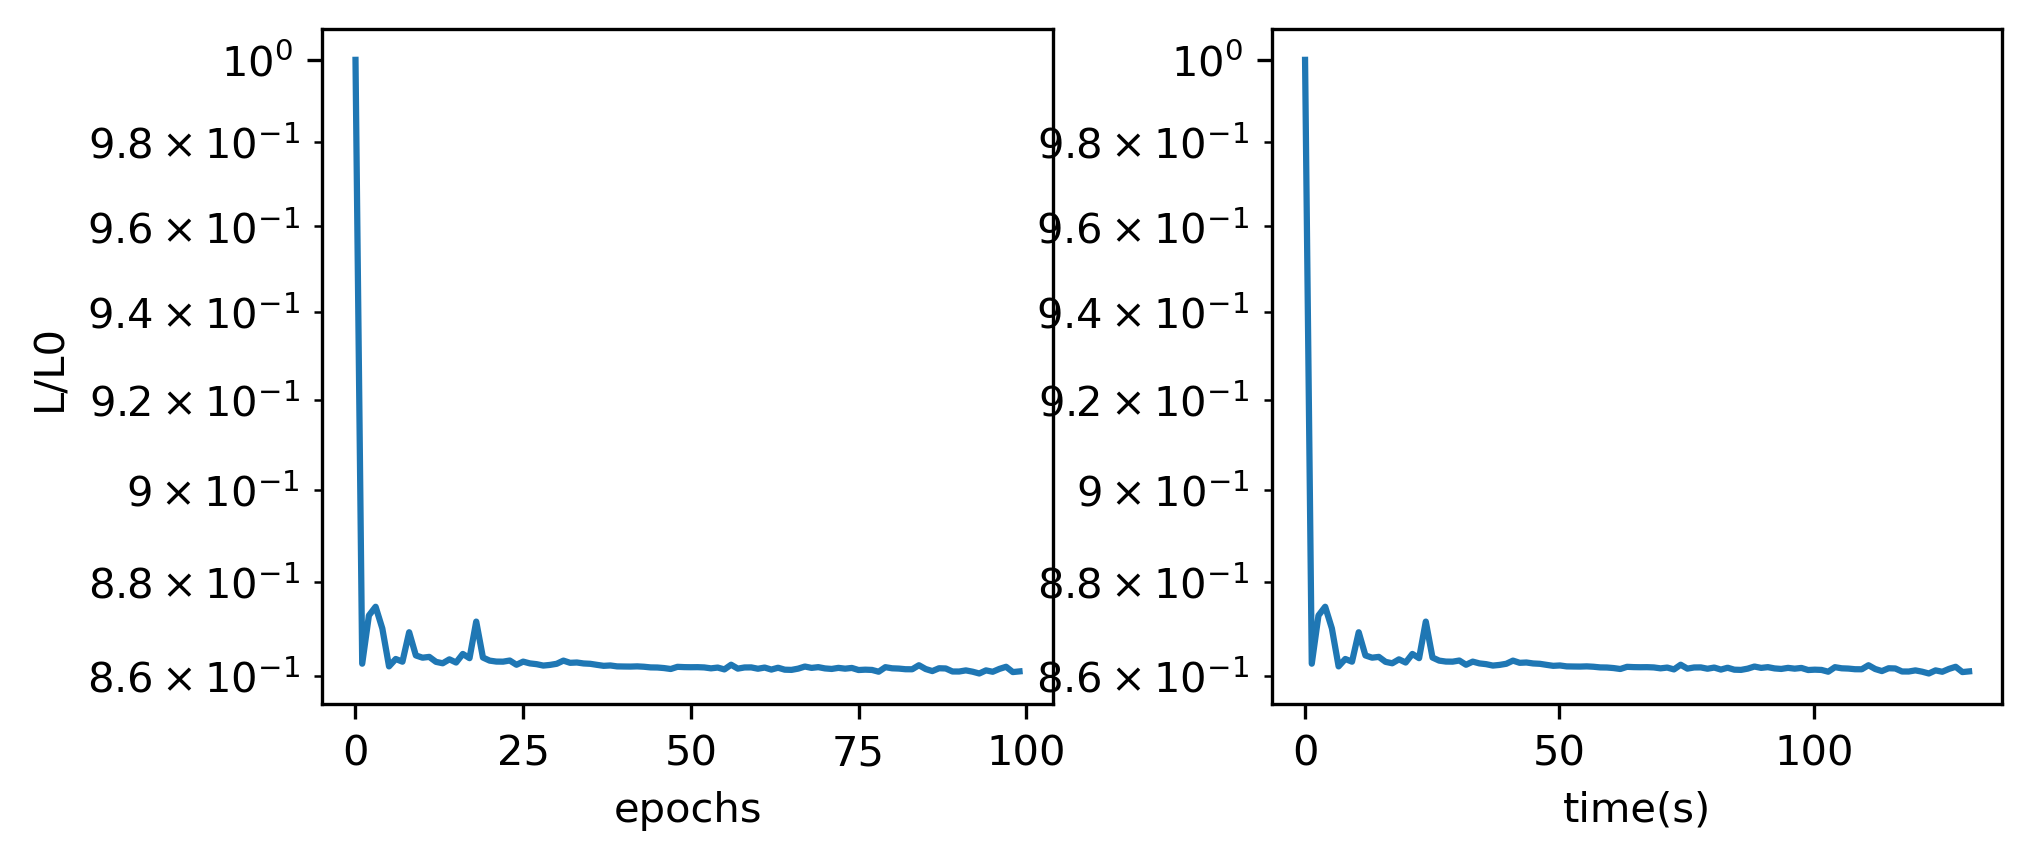

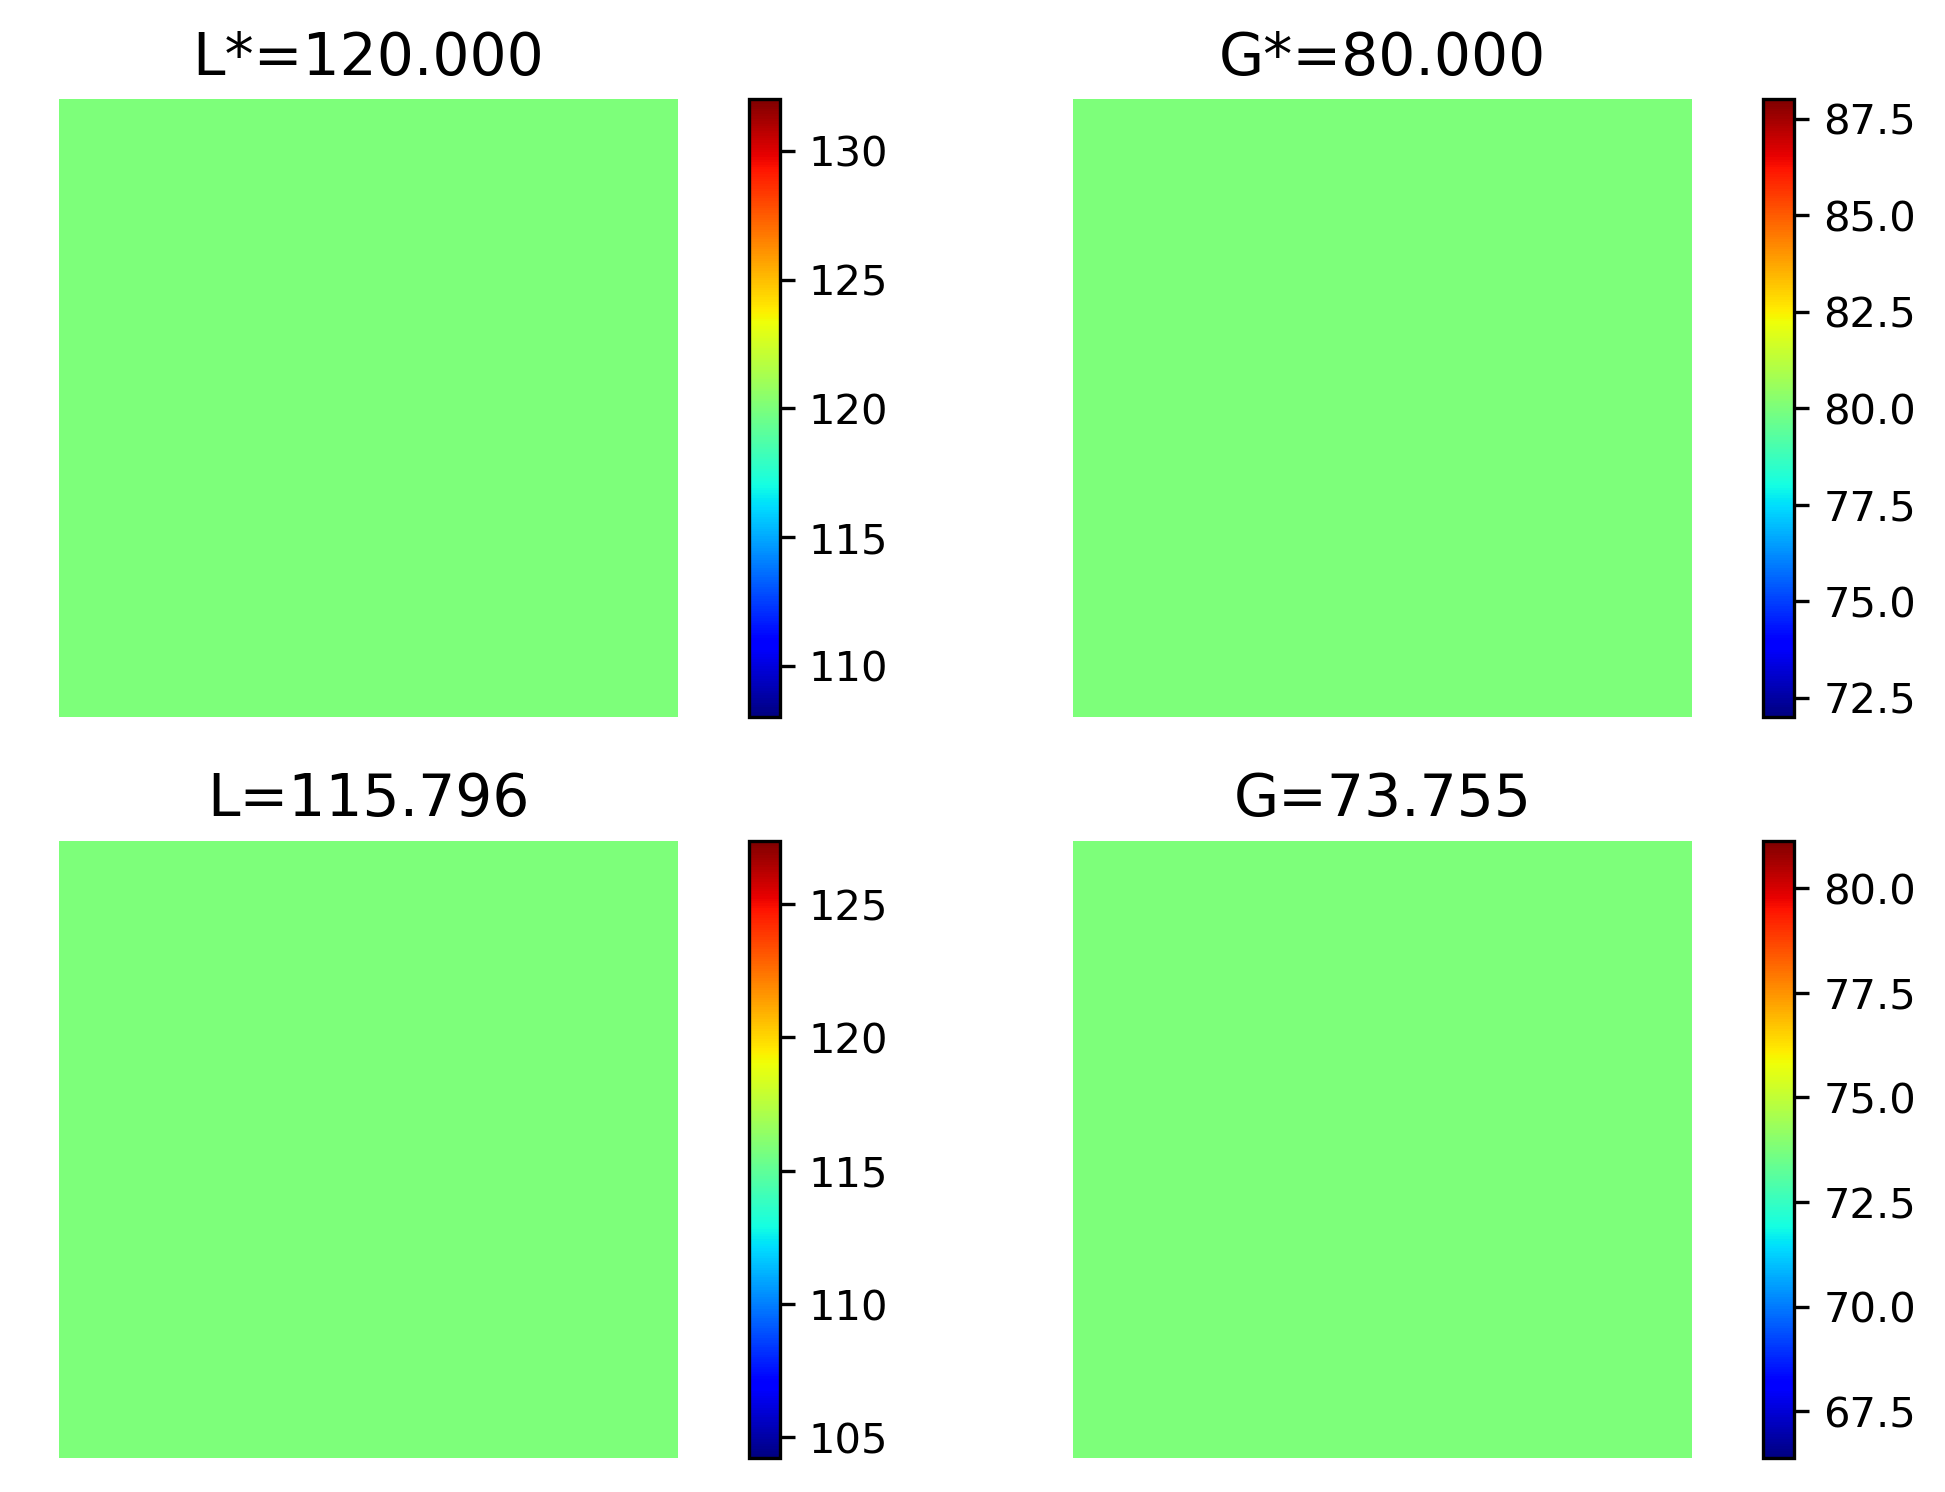

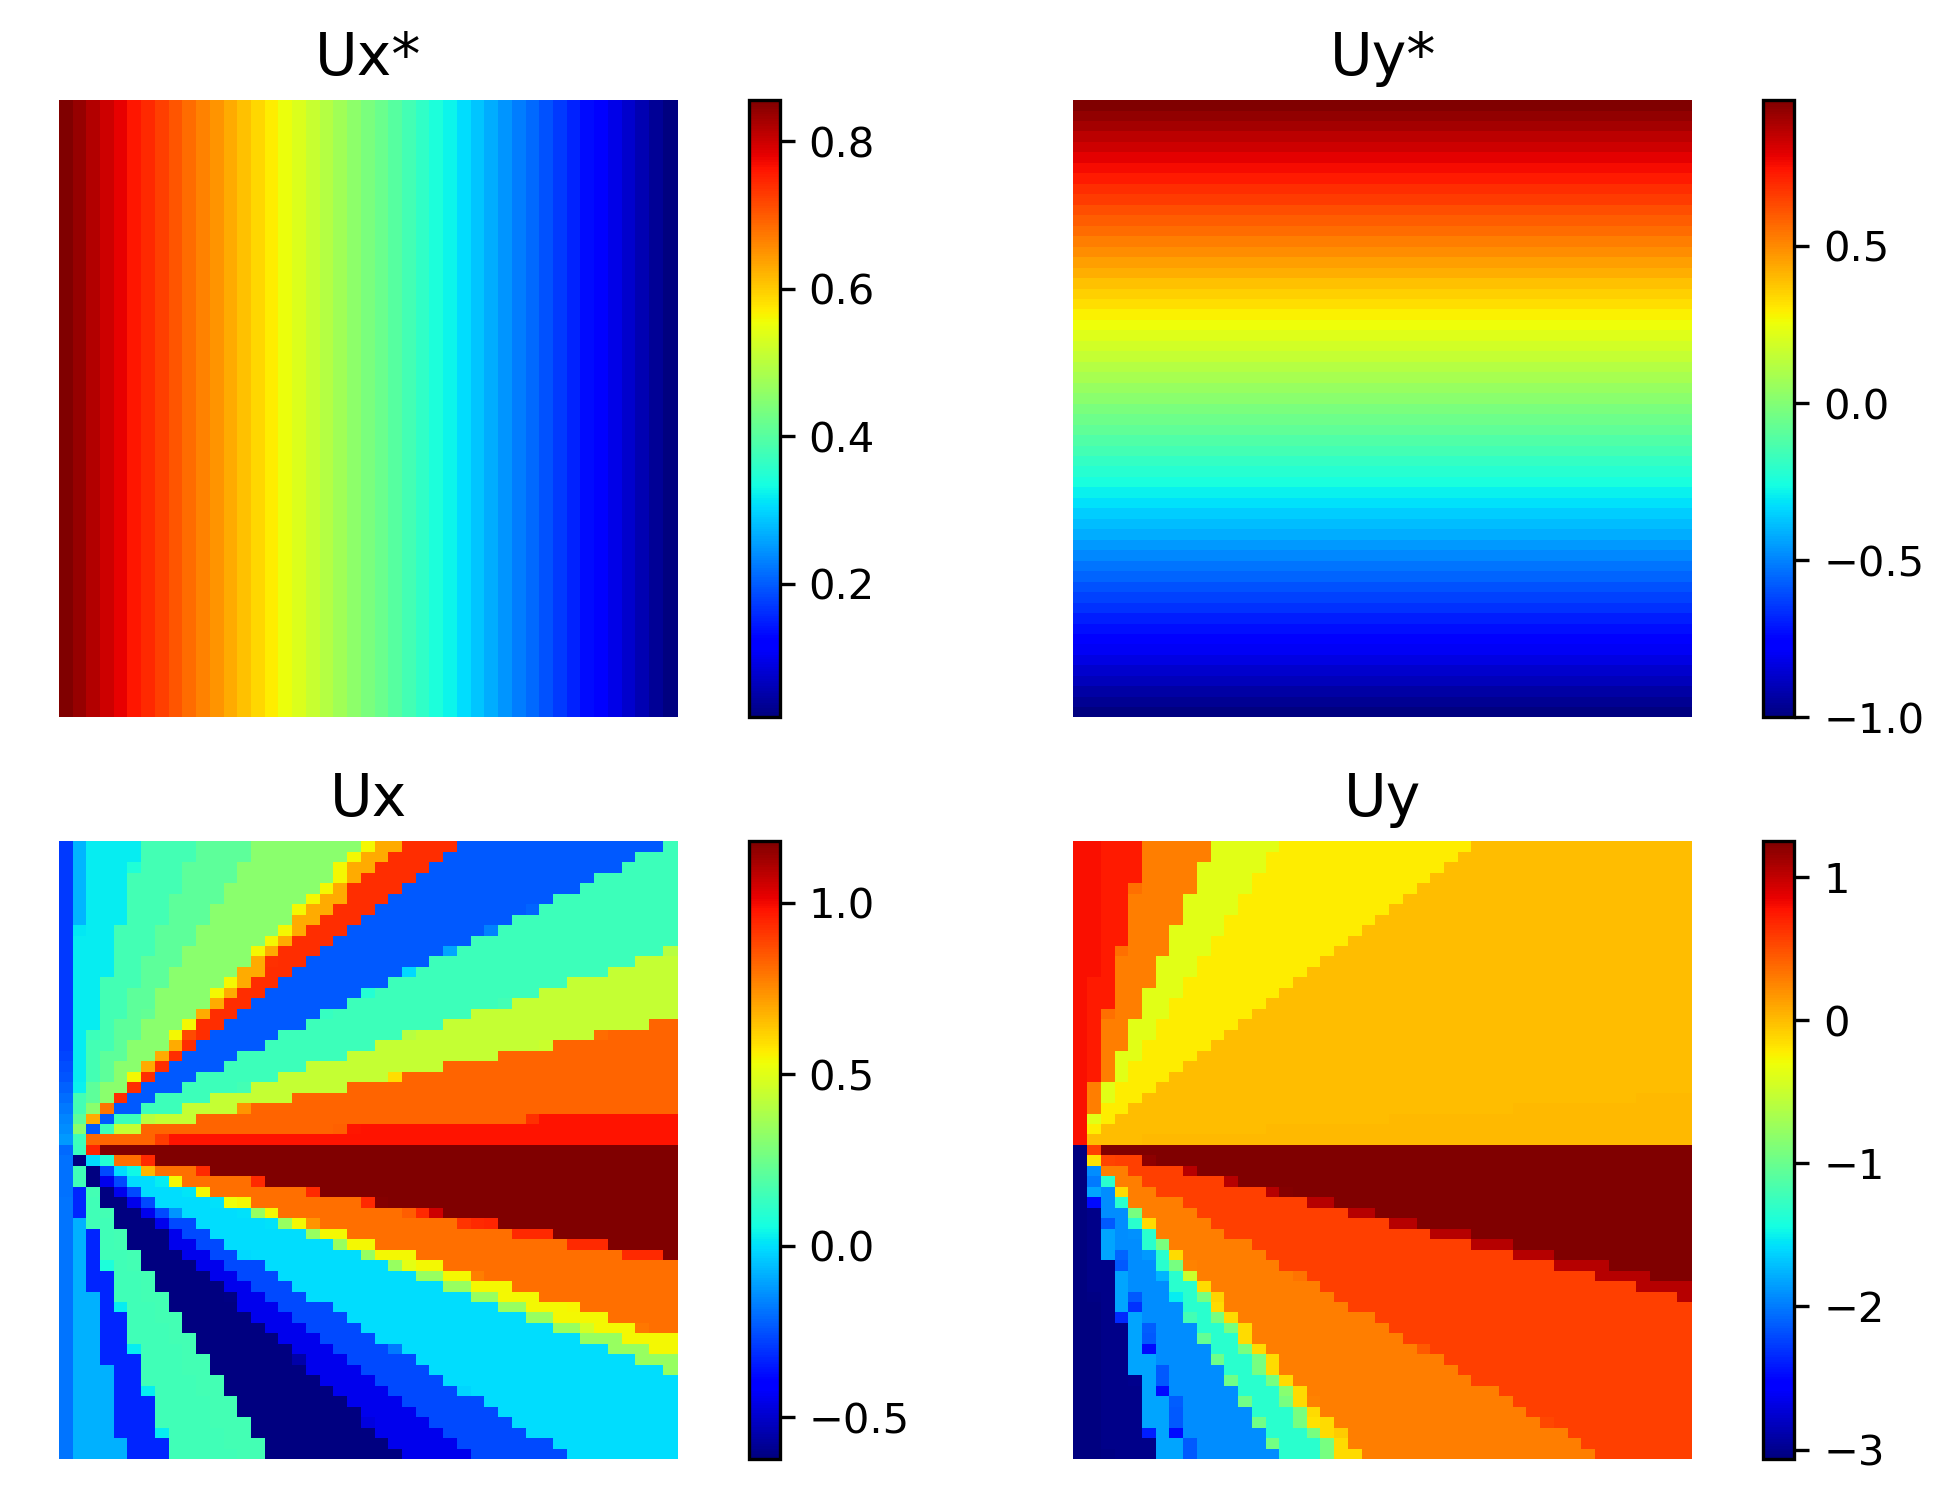

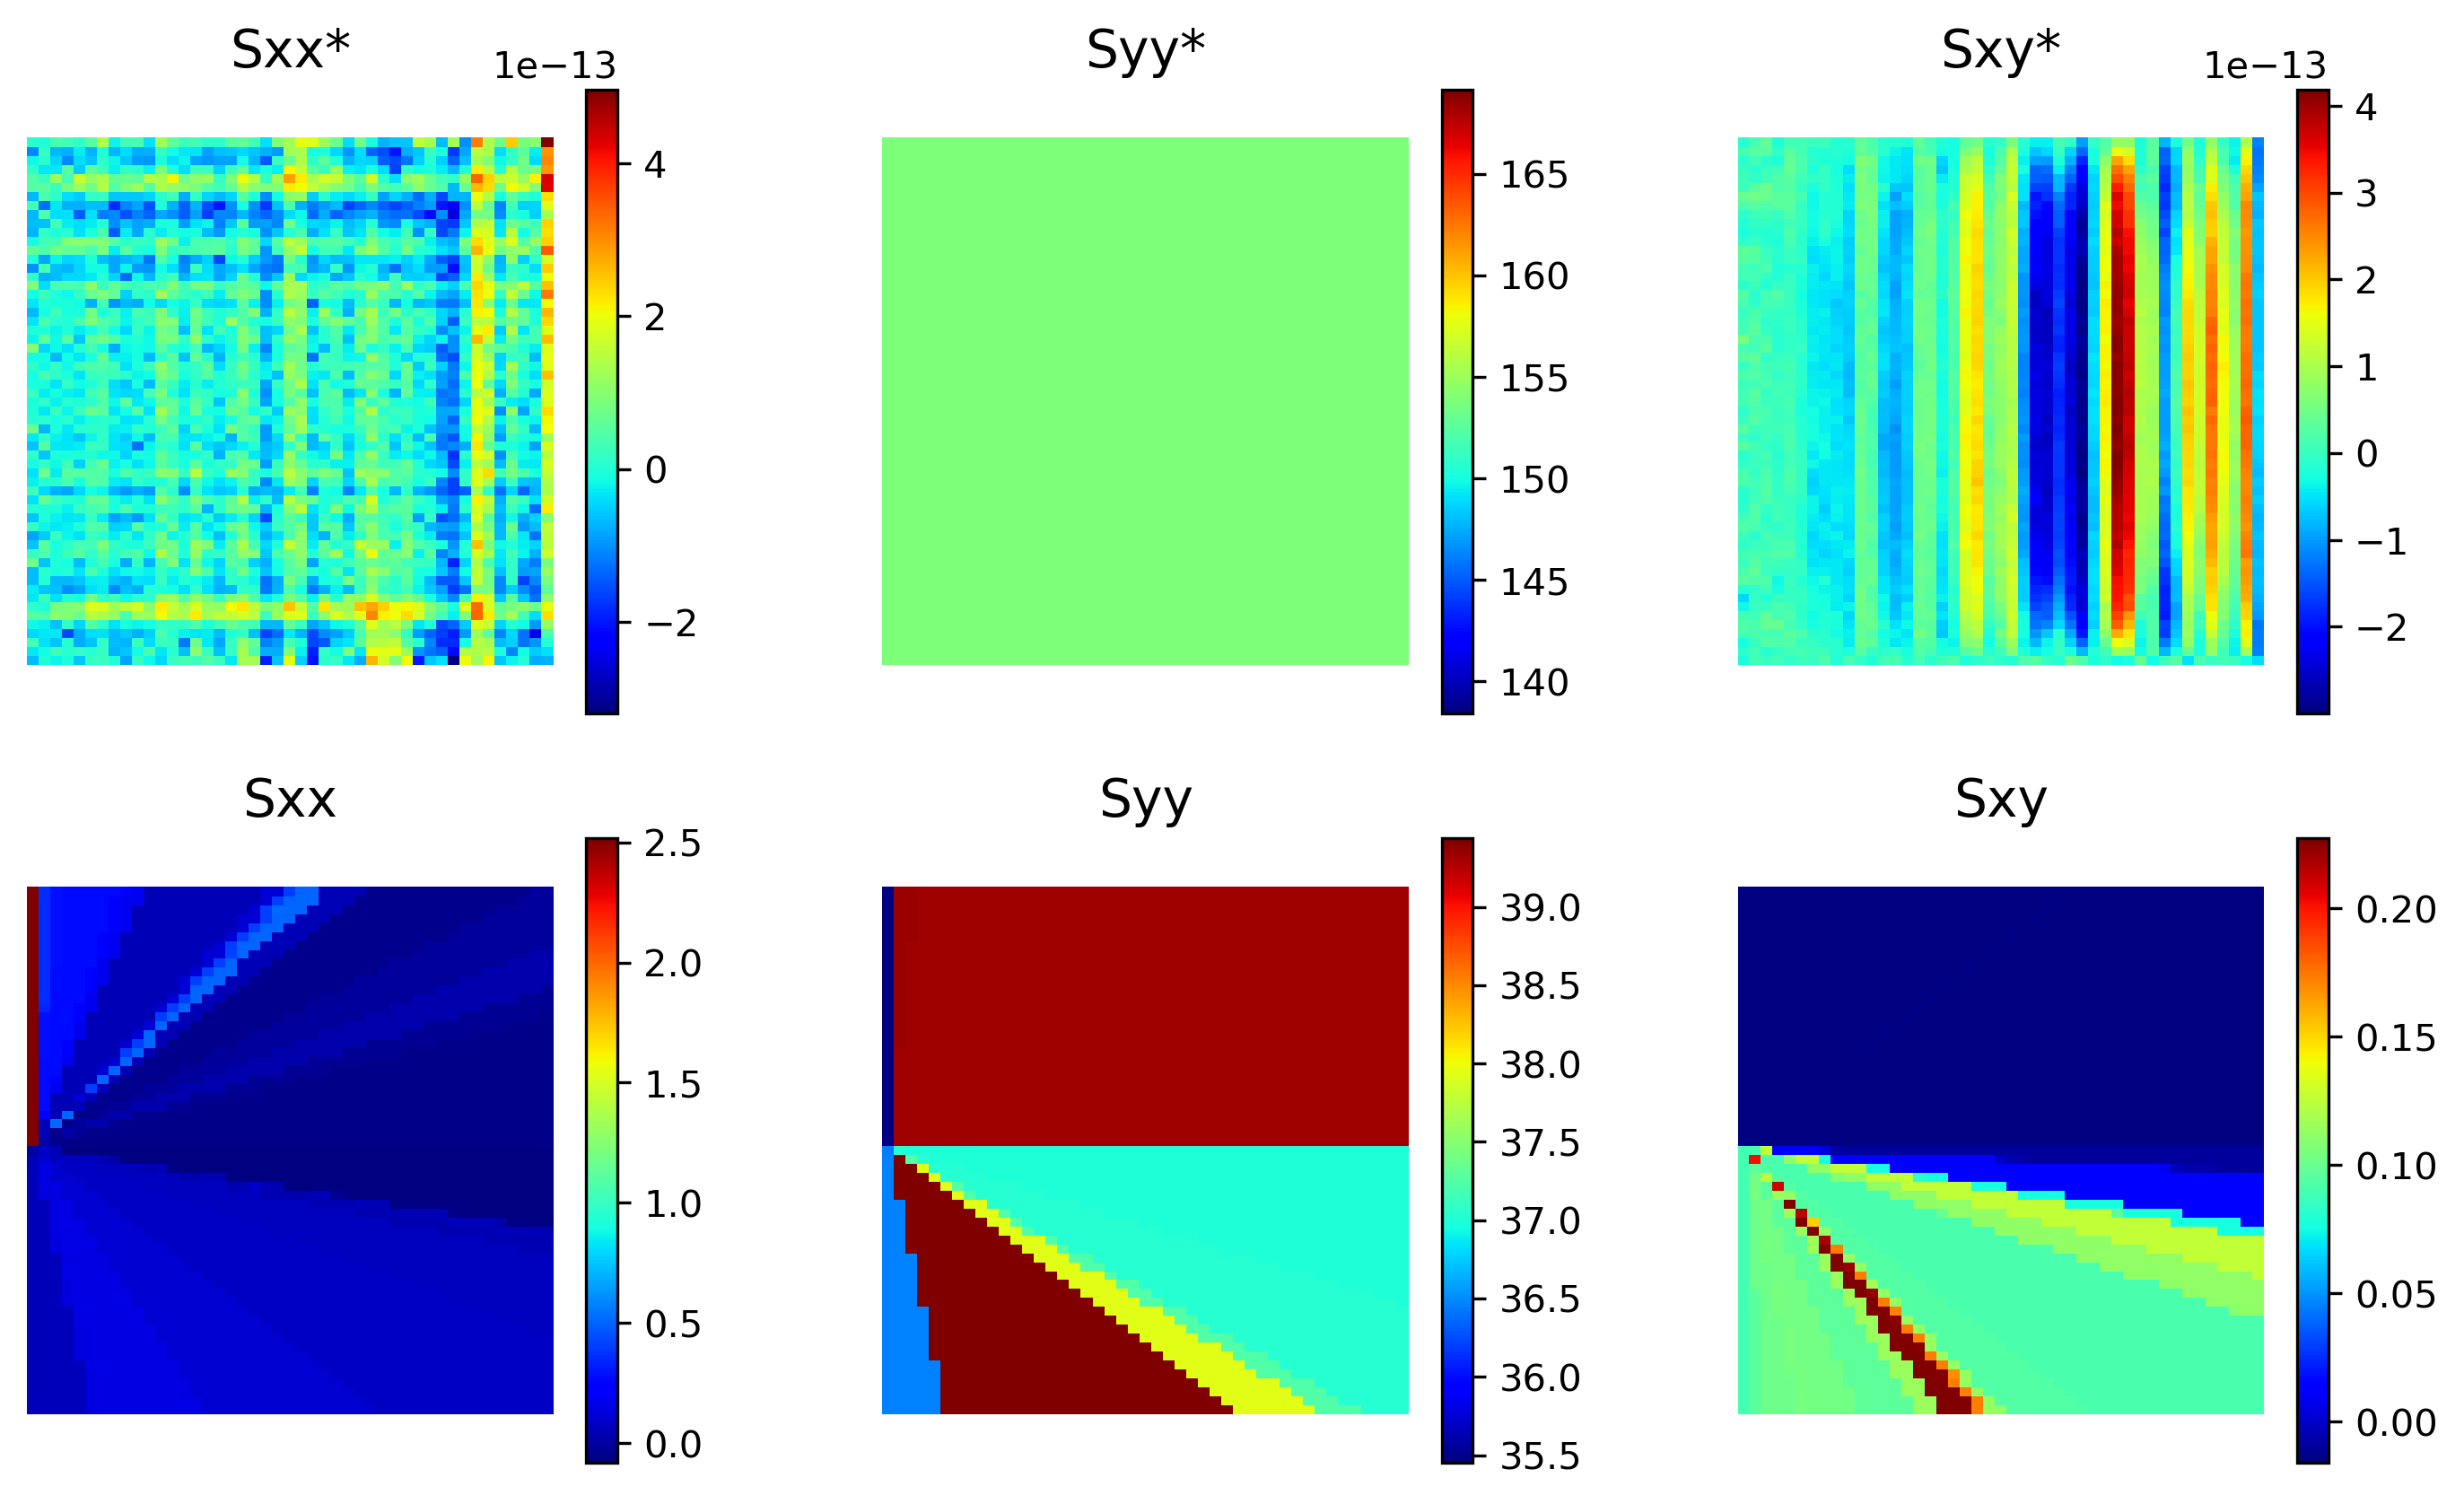

In [191]:
train()
plot()

In [8]:
input_data = set.step_080
np.asarray(input_data.sel(field='ux'))
plot_s11 = rearrange(numx, numy, np.asarray(input_data.sel(field='S11')))
np.shape(plot_s11)

(60, 46)

/tmp/ipykernel_22740/3047293428.py:77: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = AX.pcolor(X, Y, C, cmap="jet")


(60, 46)


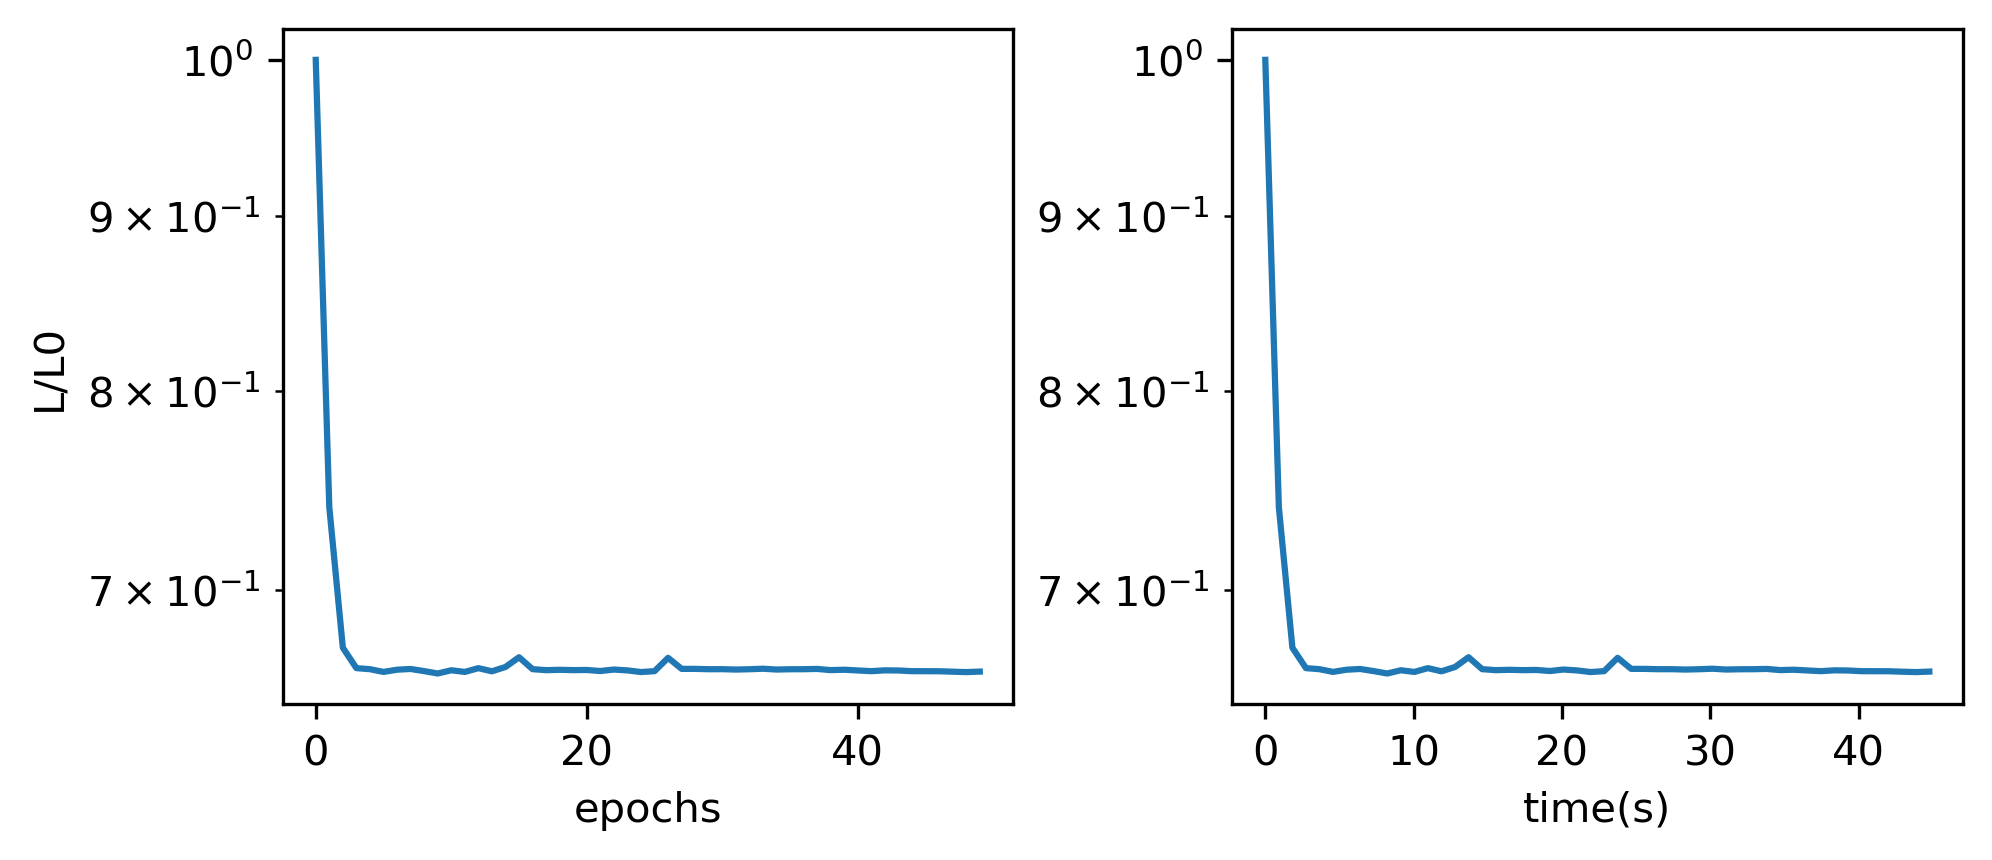

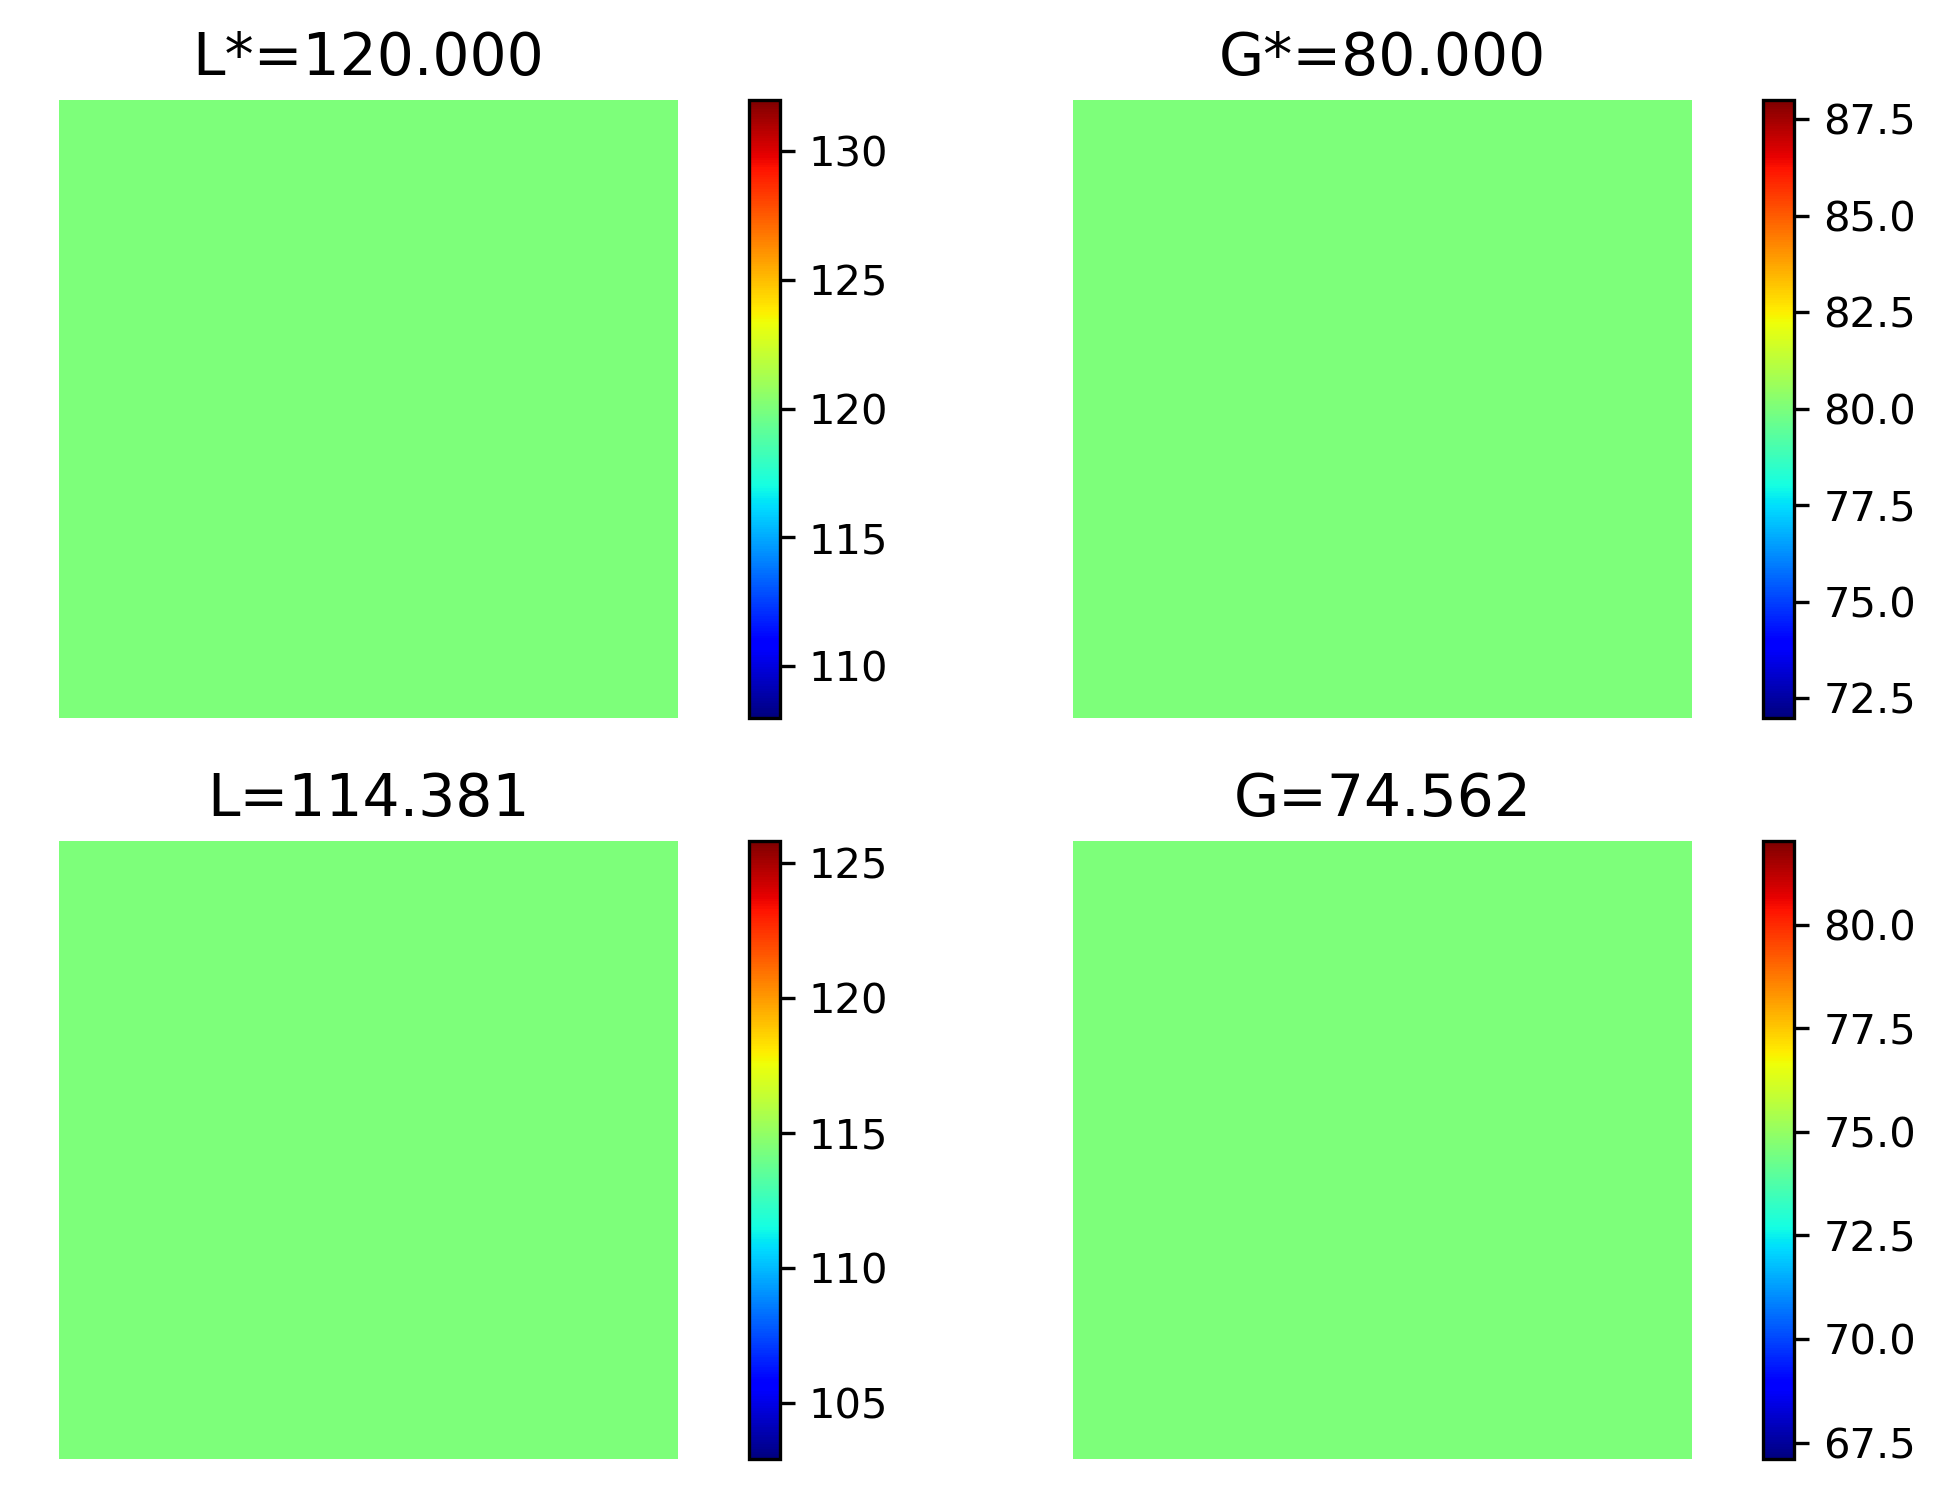

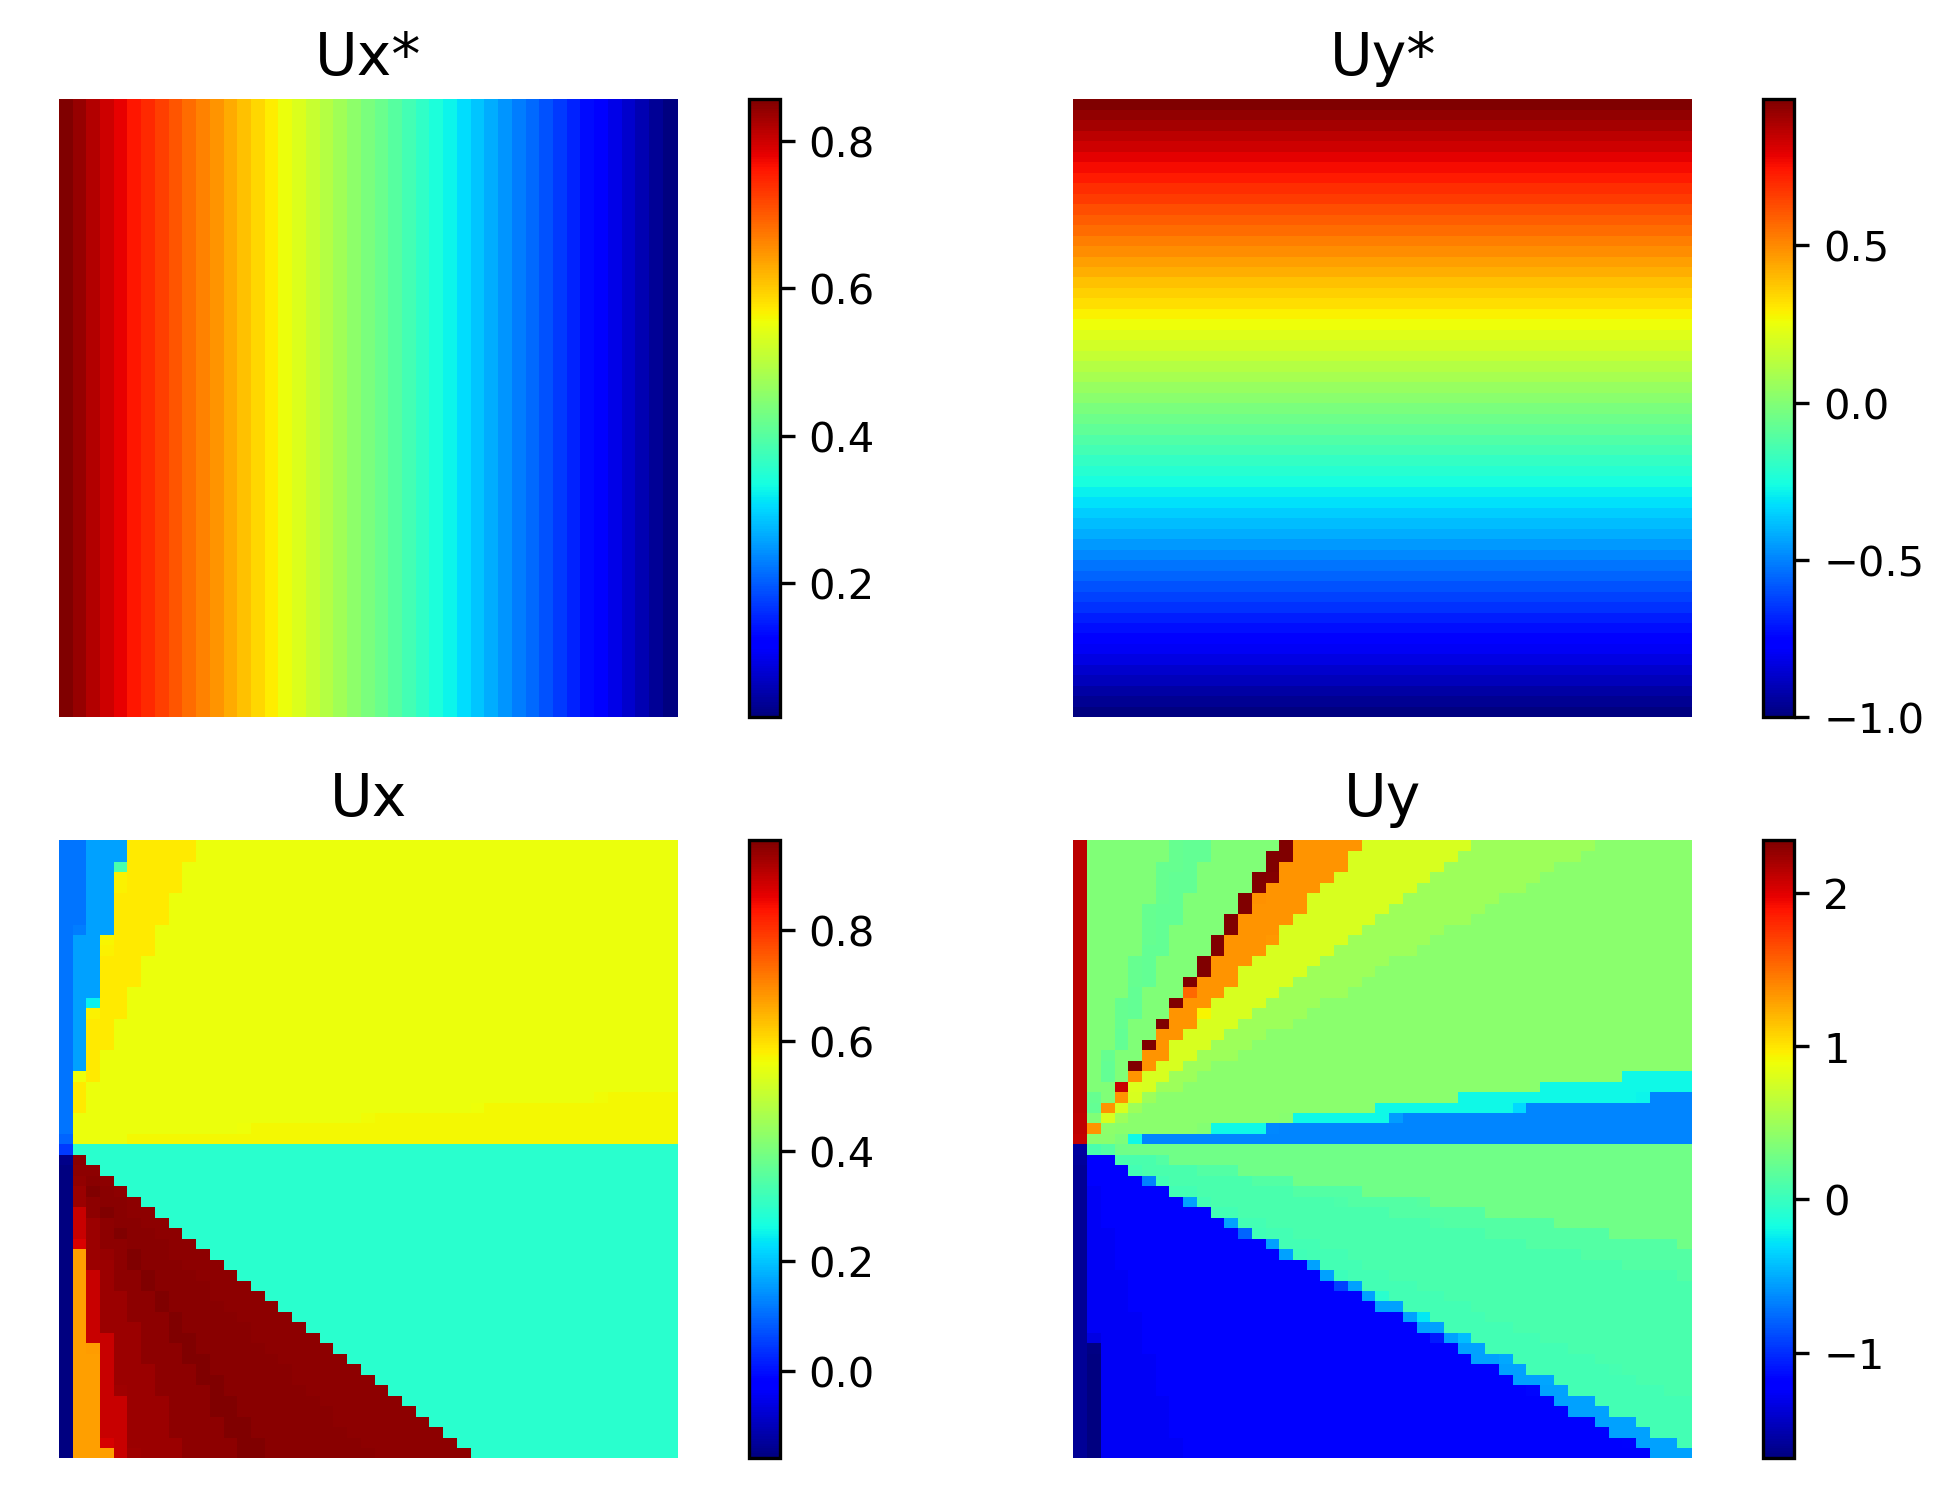

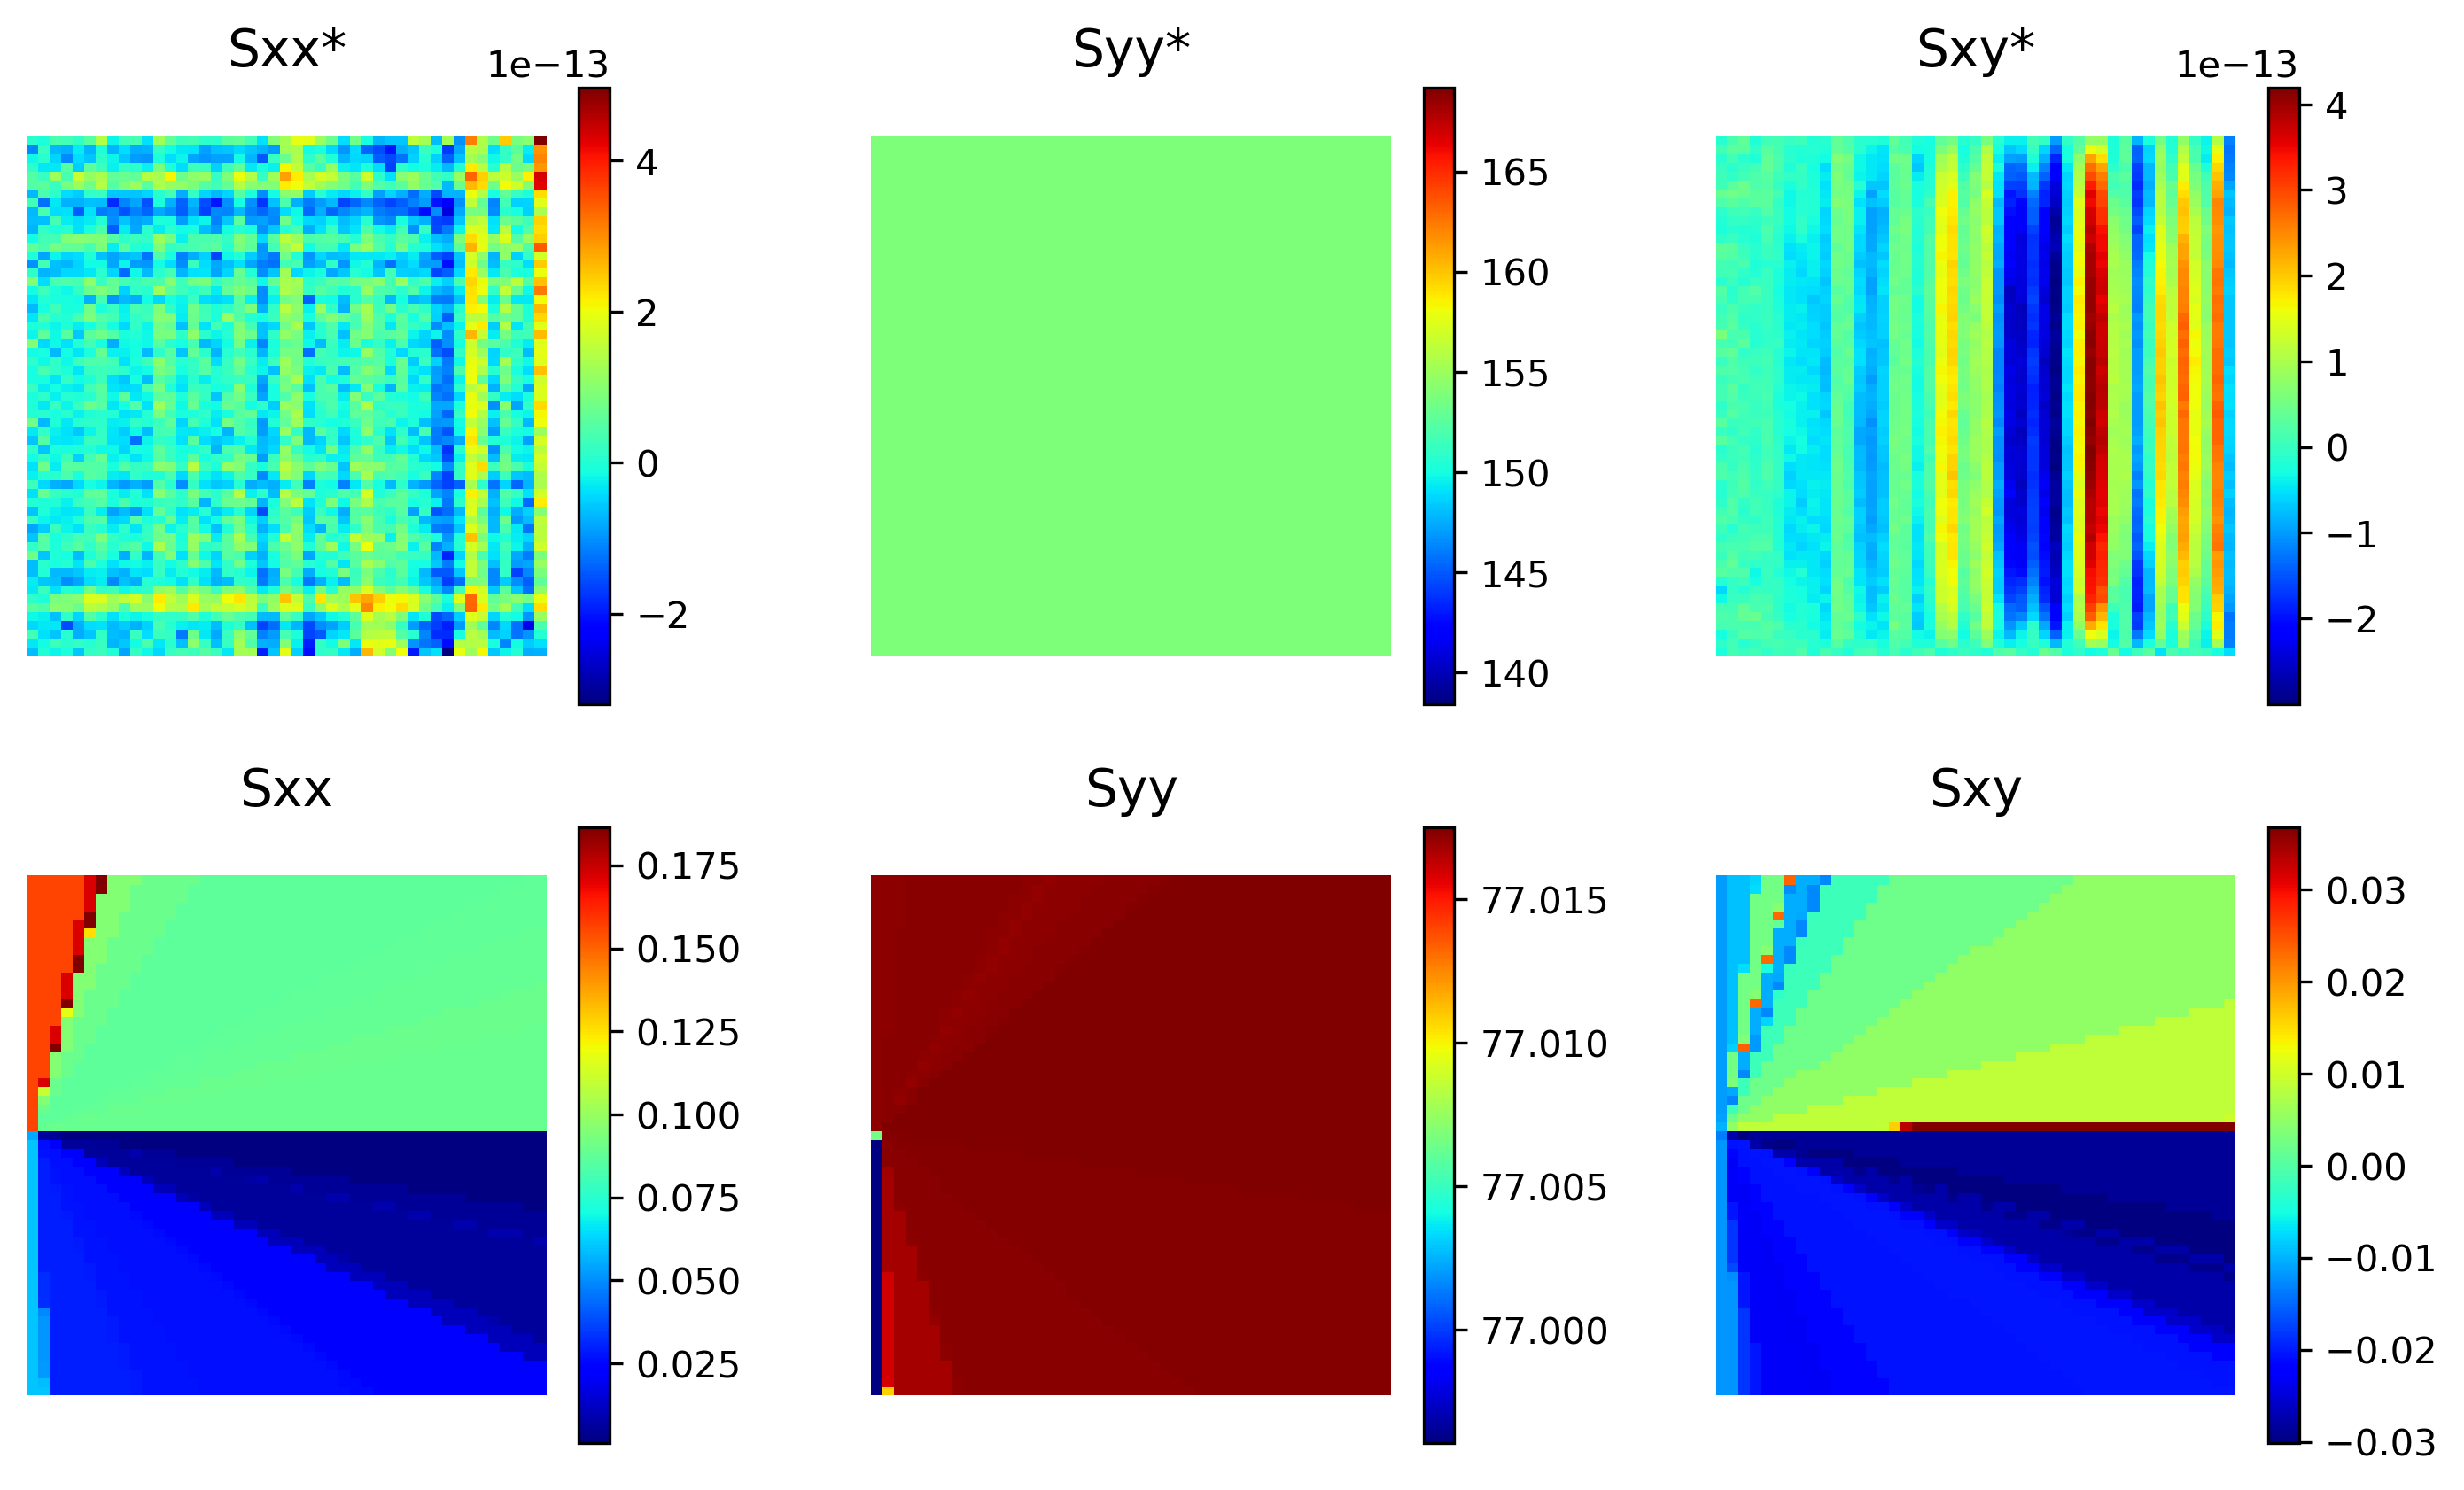

In [9]:
plot()